# Say 'Hello' to my little GAN

---



#In this notebook I will implement WGAN-GP model for two datasets: Celeba with people faces and noname dataset from kaggle, which consists of anime faces

##Libraries exporting

In [ ]:
!pip install -q git+https://github.com/kwotsin/mimicry.git torchmetrics torch-fidelity gdown
!pip install wandb
!pip install torchmetrics
import wandb
import torch
import torch_mimicry as tmim
import torchvision as tv
import gdown
import os
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import gc
import pandas as pd
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from google.colab import drive

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

#!wandb login --personal key--

For simplicity I will take architectures for generator and discriminator from open source library torch-mimicry

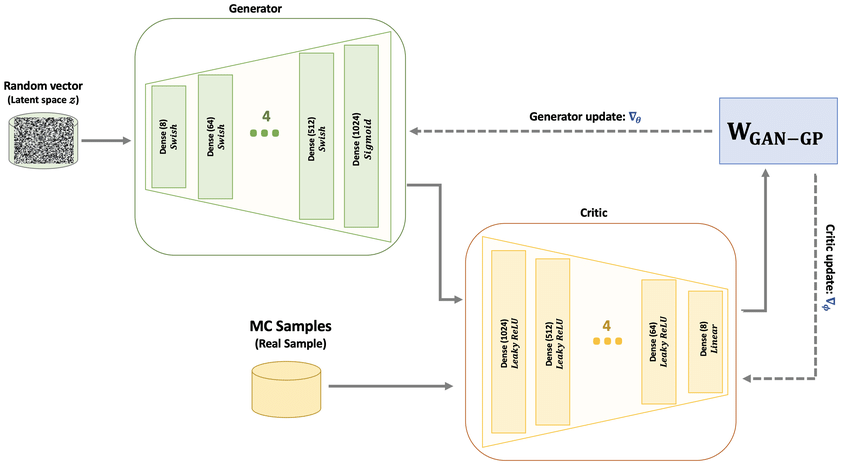

In [3]:
G = tmim.nets.wgan_gp.wgan_gp_64.WGANGPGenerator64().to(device)
D = tmim.nets.wgan_gp.wgan_gp_64.WGANGPDiscriminator64().to(device)

##Losses

In [4]:
def loss_D(d_fake,d_real):
    # define the loss of discriminator based on d_fake = D(G(z)) and d_real = D(x)
    loss=d_fake.mean() - d_real.mean()
    return loss

In [5]:
def loss_G(d_fake):
    # define the loss of generator based on output_fake = D(G(z))
    loss = -d_fake.mean()
    return loss

In [21]:
def loss_GP(x_fake,x_real,D):
    # compute gradient penalty, it supports to avoid an undefined state when G and D are reaching equilibrium
    # GP fix this problem by additional penalty for big discriminator gradients values

    #x_fake=x_fake.detach()
    a = torch.rand([x_fake.size()[0],1,1,1]).to(device)

    x_int = (a*x_real+(1-a)*x_fake).requires_grad_(True)
    d_int = D(x_int)
    out = torch.ones_like(d_int)
    grad = torch.autograd.grad(outputs=d_int, inputs=x_int,grad_outputs=out,create_graph=True,retain_graph=True)[0]

    grad = grad.view(grad.size()[0], -1)
    loss = torch.mean((torch.norm(grad,p=2,dim=1)-1)**2)
    return loss


##Some standart stuff and data exporting

In [9]:
sharing_link = 'https://drive.google.com/file/d/1XAvdeLwZLxvvRDNGYPSoqi_UgbDho9nZ/view?usp=sharing' #Celeba
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)
!unzip ./data.zip

Downloading...
From: https://drive.google.com/uc?id=1XAvdeLwZLxvvRDNGYPSoqi_UgbDho9nZ
To: /content/data.zip

  0%|          | 0.00/3.15G [00:00<?, ?B/s]
  0%|          | 11.0M/3.15G [00:00<00:28, 109MB/s]
  1%|          | 22.0M/3.15G [00:00<00:33, 94.4MB/s]
  1%|          | 34.1M/3.15G [00:00<00:32, 96.9MB/s]
  2%|▏         | 56.6M/3.15G [00:00<00:21, 141MB/s] 
  3%|▎         | 82.3M/3.15G [00:00<00:17, 180MB/s]
  3%|▎         | 101M/3.15G [00:00<00:19, 159MB/s] 
  4%|▍         | 124M/3.15G [00:00<00:17, 177MB/s]
  5%|▍         | 145M/3.15G [00:00<00:16, 186MB/s]
  5%|▌         | 164M/3.15G [00:01<00:16, 178MB/s]
  6%|▌         | 188M/3.15G [00:01<00:15, 195MB/s]
  7%|▋         | 218M/3.15G [00:01<00:13, 223MB/s]
  8%|▊         | 242M/3.15G [00:01<00:12, 228MB/s]
  8%|▊         | 265M/3.15G [00:01<00:12, 229MB/s]
  9%|▉         | 295M/3.15G [00:01<00:11, 247MB/s]
 10%|█         | 320M/3.15G [00:04<01:48, 26.0MB/s]
 11%|█         | 344M/3.15G [00:04<01:20, 34.9MB/s]
 12%|█▏        | 363

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_nose.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_skin.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_u_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_hair.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_mouth.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_nose.png  
  inflating: 

In [10]:
class DataSet():
  def __init__(self,folder,name):
    self.folder = folder
    self.names = name
    self.transforms = transforms.Compose([
      transforms.Resize((64,64)),
      transforms.ToTensor(),
      transforms.Normalize(0.5,0.5,0.5)
    ])

  def __len__(self):
    return len(self.names)

  def __getitem__(self,idx):
    file = self.names[idx]
    path = self.folder+file
    img = self.transforms(Image.open(path))
    return img


In [11]:
def save_model_torch(model,name='WGan'):
  drive.mount('/content/drive/')
  model_save_name=name
  path=f'/content/drive/MyDrive/models/{model_save_name}'
  torch.save(model.state_dict(), path)

In [12]:
def load_model_torch(model,name='WGan'):
  model = model
  drive.mount('/content/drive/')
  path=f'/content/drive/MyDrive/models/{name}'
  state_dict = torch.load(path)
  model.load_state_dict(state_dict)
  return model

In [15]:
names_celeba = os.listdir('./CelebAMask-HQ/CelebA-HQ-img/')

In [16]:
sharing_link = 'https://drive.google.com/file/d/1H7SM_2Y4Fhqc4yhR2HPS_RqEzNiLOXKw/view?usp=drive_link' #anime faces
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)
!unzip ./data.zip
names_anime = os.listdir('./data/data/')

Downloading...
From: https://drive.google.com/uc?id=1H7SM_2Y4Fhqc4yhR2HPS_RqEzNiLOXKw
To: /content/data.zip

  0%|          | 0.00/462M [00:00<?, ?B/s]
  2%|▏         | 8.39M/462M [00:00<00:05, 83.2MB/s]
  4%|▎         | 16.8M/462M [00:00<00:12, 37.1MB/s]
  5%|▍         | 22.0M/462M [00:00<00:19, 22.9MB/s]
  6%|▌         | 25.7M/462M [00:00<00:19, 22.7MB/s]
  7%|▋         | 34.1M/462M [00:01<00:19, 21.5MB/s]
  9%|▉         | 42.5M/462M [00:01<00:14, 29.5MB/s]
 11%|█         | 50.9M/462M [00:01<00:10, 37.8MB/s]
 14%|█▍        | 65.0M/462M [00:01<00:06, 57.0MB/s]
 16%|█▋        | 76.0M/462M [00:01<00:05, 67.6MB/s]
 18%|█▊        | 84.9M/462M [00:01<00:05, 71.4MB/s]
 22%|██▏       | 101M/462M [00:02<00:04, 78.6MB/s] 
 26%|██▌       | 118M/462M [00:02<00:03, 88.6MB/s]
 29%|██▉       | 135M/462M [00:02<00:03, 91.6MB/s]
 33%|███▎      | 152M/462M [00:02<00:03, 87.5MB/s]
 36%|███▌      | 166M/462M [00:02<00:03, 98.2MB/s]
 38%|███▊      | 177M/462M [00:02<00:03, 78.1MB/s]
 42%|████▏     | 193M

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/da

##Train part

In [17]:
batch_size = 64
dataset_celeba = DataSet('./CelebAMask-HQ/CelebA-HQ-img/', names_celeba)
dataset_anime = DataSet('./data/data/', names_anime)
dataloader_celeba = DataLoader(dataset_celeba, batch_size=batch_size, shuffle=True)
dataloader_anime = DataLoader(dataset_anime, batch_size=batch_size, shuffle=True)
optimizer_G = torch.optim.Adam(G.parameters(),lr=2e-4,betas=(0,0.9))
optimizer_D = torch.optim.Adam(D.parameters(),lr=2e-4,betas=(0,0.9))

In [68]:
from torchmetrics.image.fid import FrechetInceptionDistance as FID
#calculating FID metric will be used as validation
def check_FID(G,dataloader,device='cuda'):
  fid = FID(normalize=True).to(device)
  for data in tqdm(dataloader):
    fid.update(data.to(device)/2+0.5,real=True)
  for i in tqdm(range(30000//batch_size)):
    fid.update(G(torch.randn(batch_size,128,device=device))/2+0.5,real=False)
  return fid.compute()

In [19]:
from PIL import Image
from torchvision.utils import make_grid

def requires_grad(G,D,flag='G'):
  if flag=='G':
    for param in G.parameters():
      param.requires_grad=True
    for param in D.parameters():
      param.requires_grad=False
  if flag =='D':
    for param in G.parameters():
      param.requires_grad=False
    for param in D.parameters():
      param.requires_grad=True

def train(G,D,dataloader,optimizer_G,optimizer_D,rand_tensor = torch.randn(8,128,device=device),n_dis=2,n_iters=2500,gp=10,batch_size=64):
  wandb.init(
        project="Little_WGAN_ANIME",
        config={
            "architecture": "WGAN",
            "dataset": "Anime",
            "n_dis": n_dis,
            "gp": gp,
            'batch':batch_size
            })

  pbar = tqdm(range(n_iters))
  device = 'cuda'
  gp=torch.tensor(gp).to(device)
  image_dir = '/content/drive/MyDrive/anime_faces/'
  MA_20_Loss_G = [0]*20
  MA_20_Loss_D = [0]*20
  fid = 0
  for i in pbar:
    if i in [1,10,50,100,250,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,15000]:
      print()
      example = transforms.ToPILImage()(make_grid(G(rand_tensor).detach().cpu(),normalize=True,nrow=8))
      plt.imshow(example)
      plt.title(f'Iter {i+38500}')
      plt.savefig(f'{image_dir}Anime_iter_{i}.png')
      plt.show();
      images = wandb.Image(
      example,
      caption=f"Iter {i}"
      )
      wandb.log({'Example':images})

    requires_grad(G,D,'D')
    #garbage collector
    if i%500==0 and i//500>=1:
      torch.cuda.empty_cache()
      gc.collect()

    #fid metric as validation
    if i%2000==0 and i//2000>=1:
      fid = check_FID(G,D,dataloader)
      print('----'*10)
      print('FID=',fid)
      print('----'*10)
    #decor train
    for j in range(n_dis):

      real=next(iter(dataloader)).to(device)
      rand = torch.randn(batch_size,128).to(device)
      fake=G(rand)

      label_real = D(real).reshape(-1)
      label_fake = D(fake).reshape(-1)

      lossD = loss_D(label_fake, label_real) + gp*loss_GP(fake, real, D)

      optimizer_D.zero_grad()
      lossD.backward(retain_graph=True)
      optimizer_D.step()

    #train generator for 1 iteration
    requires_grad(G,D,'G')

    label_fake = D(G(torch.randn(batch_size,128,device=device))).reshape(-1)

    lossG = loss_G(label_fake)

    optimizer_G.zero_grad()
    lossG.backward()
    optimizer_G.step()
    MA_20_Loss_G.append(lossG.item())
    MA_20_Loss_D.append(lossD.item())
    MA_20_Loss_G.pop(0)
    MA_20_Loss_D.pop(0)
    pbar.set_description(f"Loss D {lossD.item()} Loss G {lossG.item()}")
    #wandb.log({"G_loss": lossG.item(), "D_loss": lossD.item(),"MA_20_Loss_G":np.mean(MA_20_Loss_G),'MA_20_Loss_D':np.mean(MA_20_Loss_D),'FID':fid})
    if i//500>=1 and i%500==0:
      save_model_torch(G,f'G_Anime_{i+38500}')
      save_model_torch(D,f'D_Anime_{i+38500}')



  wandb.finish()
  return G,D

In [20]:
torch.manual_seed(0)
rand_tensor = torch.randn(8,128,device=device)

In [ ]:
from google.colab import files,drive
torch.cuda.empty_cache()
gc.collect()
drive.mount('/content/drive/')
G, D= train(G,D,dataloader_celeba,optimizer_G,optimizer_D,rand_tensor=rand_tensor,n_dis=2,n_iters=10000,batch_size=batch_size)

##Wandb reports


For trainin models i'm using free version of google colab, it doesn't give enough time to reach good results, so i'm doing it by parts using presaved models.

**Celeba generation for first 5000 iterations**
https://wandb.ai/vgrig/Little_GAN/reports/WGAN-GP-CELEBA--Vmlldzo1MDc4NzY0

**Anime generation for first 9000 iterations** https://wandb.ai/vgrig/Little_WGAN_ANIME/reports/Little-WGAN-GP--Vmlldzo1MDc4ODEw

**Also, I will duplicate results for anime model here and show the performence of resulted WGAN for Celeba**

##Results Anime

In [28]:
from google.colab import files,drive
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

torch.cuda.empty_cache()
gc.collect()
drive.mount('/content/drive/')

loss = pd.read_csv('/content/drive/MyDrive/anime_data.csv') # from wandb logging
imgs_path = '/content/drive/MyDrive/anime_faces/'
imgs_names = os.listdir(imgs_path)
images = [Image.open(imgs_path+i) for i in imgs_names]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
loss_G = loss['effortless-cloud-8 - G_loss']
loss_D = loss['effortless-cloud-8 - D_loss']
loss_FID = loss['effortless-cloud-8 - FID']

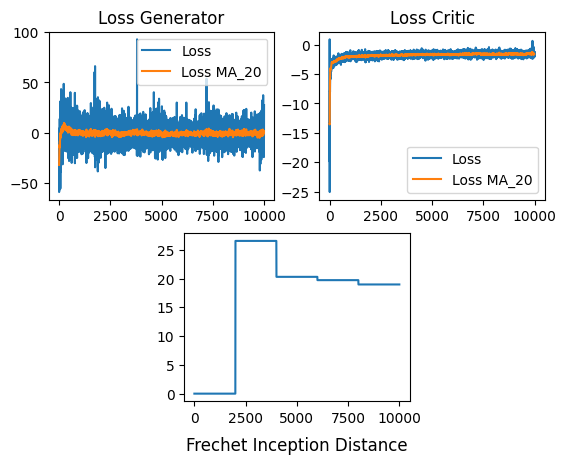

In [25]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

loss_G_MA = [np.mean(loss_G[i:i+20]) for i in range(len(loss_G)-20)]
loss_D_MA = [np.mean(loss_D[i:i+20]) for i in range(len(loss_D)-20)]
ax1.set_title('Loss Generator')
ax2.set_title('Loss Critic')
ax3.set_title('Frechet Inception Distance', y=0, pad=-25, verticalalignment="top")

ax1.plot([i for i in range(len(loss_G))],loss_G,label='Loss')
ax1.plot([i for i in range(len(loss_G_MA))],loss_G_MA,label='Loss MA_20')
ax2.plot([i for i in range(len(loss_D))],loss_D,label='Loss')
ax2.plot([i for i in range(len(loss_D_MA))],loss_D_MA,label='Loss MA_20')
ax3.plot([i for i in range(len(loss_FID))],loss_FID)

ax1.legend()
ax2.legend()
plt.show()

In [26]:
images = []
for i in imgs_names:
  images.append(Image.open(imgs_path+i))

def animate(images):
    fig = plt.figure()
    fig.patch.set_visible(False)
    plt.axis('off')
    ims = []
    for i in range(len(images)):
        im = plt.imshow(images[i], animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat_delay=1000)
    return ani

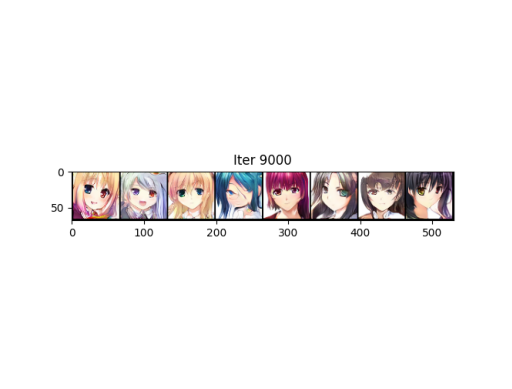

In [27]:
ani = animate(images)
HTML(ani.to_jshtml())

##Results Celeba

In [30]:
G = load_model_torch(G,'G_58000')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


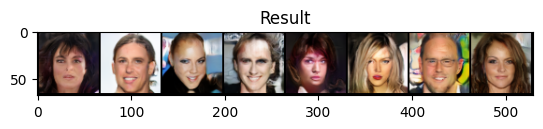

In [66]:
from PIL import Image
from torchvision.utils import make_grid
device='cuda'
rand_tensor = torch.randn(8,128,device=device)
example = transforms.ToPILImage()(make_grid(G(rand_tensor).detach().cpu(),normalize=True,nrow=8))
plt.imshow(example)
plt.title(f'Result')
plt.show();

As easy to see they are not ideal, I think the main reason is that in Celeba ds there are many photos from different angles and provided pitch, roll, yaw values, to show the best performence it's better to select only direct views and to train approx for 100000 it.

In [69]:
check_FID(G,dataloader_celeba)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 155MB/s]
100%|██████████| 468/468 [02:59<00:00,  2.61it/s]


tensor(10.0939, device='cuda:0')